In [7]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import codecs

import os
import ctypes
import time
from matplotlib import pyplot as plt

import collections
from collections import Counter

import csv
from operator import itemgetter

import networkx as nx
import networkx as nx
from networkx.algorithms import community

from itertools import combinations

In [9]:
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Co-Authorship Network

In [10]:
#import main dataset
df_main = pd.read_csv('combined_WoS')
print(df_main.shape)
df_main['AR']

(4722, 67)


0          10.1109/TAES.2010.5595582
1                  10.1021/ef100972f
2         10.1016/j.fuel.2010.03.040
3         10.1016/j.fuel.2010.01.019
4        10.1016/j.ifset.2010.06.006
                    ...             
4717       10.1007/s11276-010-0253-3
4718     10.1016/j.desal.2010.04.010
4719    10.1016/j.cattod.2009.11.015
4720               10.1021/ie100329z
4721        10.1109/LPT.2010.2066555
Name: AR, Length: 4722, dtype: object

In [11]:
#import co-author biblio-dataset
df_bib = pd.read_csv('SUPPORT_Co-Author_t=full.csv')
print(df_bib.shape)
#df_bib['DOI']
df_bib.head(1)

(3518, 3)


,DOI,author,year
0,10.1109/taes.2010.5595582,Todd E. Humph and Mark L. Psiaki and Brent M. ...,2010


In [12]:
#set DOI as index for both dataframes
##########################################################
df_main = df_main.set_index('AR')
df_bib = df_bib.set_index('DOI')

In [13]:
df = pd.merge(df_bib, df_main, left_index=True, right_index=True)
print(df.shape)
df.head(1)

(2511, 68)


,author,year,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,SE,BS,LA,DT,CT,CY,CL,SP,HO,DE,ID,AB,C1,RP,EM,RI,OI,FU,FX,CR,NR,TC,Z9,U1,U2,PU,PI,PA,SN,EI,BN,J9,JI,PD,PY,VL,IS,PN,SU,SI,MA,BP,EP,DI,D2,EA,PG,WC,SC,GA,UT,PM,OA,HC,HP,DA
10.1002/ad.2505,Roger Howie,2019,"Howie, R",NaN,NaN,NaN,"Howie, Roger",NaN,NaN,Test Bed: Communication Through Product Design,ARCHITECTURAL DESIGN,NaN,NaN,English,Article,NaN,NaN,NaN,NaN,NaN,Zaha Hadid Architects (ZHA); Zaha Hadid Design...,NaN,Zaha Hadid Architects has become a global bran...,"[Howie, Roger] Zaha Hadid Architects, London, ...","Howie, R (reprint author), Zaha Hadid Architec...",NaN,NaN,NaN,NaN,NaN,"Giovannini Joseph, 2013, FAST FORWARD, P33; He...",2,0,0,1,1,"WILEY PERIODICALS, INC",SAN FRANCISCO,"ONE MONTGOMERY ST, SUITE 1200, SAN FRANCISCO, ...",0003-8504,1554-2769,NaN,ARCHIT DESIGN,Archit. Des.,NOV,2019.0,89.0,6,NaN,NaN,SI,NaN,74,79,NaN,NaN,NaN,6,Architecture,Architecture,JI6UV,WOS:000493603100013,NaN,NaN,NaN,NaN,2020-03-09,NaN


In [14]:
## generic function to generate co-authorship network
##########################################################
def create_co_authorship_network(df,min_time,max_time):
    df = df[df['PD'] <= max_time]
    df = df[df['PD'] >= min_time]
    df_authors = df['GP'].str.split(';', 20, expand=True)
    df_authors = df_authors.replace(np.nan,np.nan)
    
    #all combinations (all with all)
    df_authors['combinations'] = df_authors.apply(lambda r: list(combinations(r, 2)), axis=1)
    count_row = df_authors.shape[0]-1
    dataframe = pd.DataFrame([])
    
    for i in range(count_row):
        res = df_authors.combinations.iloc[i]
        res = pd.DataFrame(res)
        res = res.dropna()
        dataframe = dataframe.append(res, ignore_index=True)
        
    df_co_authors = dataframe
    df_co_authors.columns =['AUTHOR', 'CO-AUTHOR'] 
    
    return df_co_authors
    #return df_authors

In [15]:
#temporal co-authorship 
##########################################################

#T3
data_t1 = create_co_authorship_network(df,1999,2005)
#T2
data_t2 = create_co_authorship_network(df,2006,2012)
#T1
data_t3 = create_co_authorship_network(df,2013,2019)

#data for complete timeframe
data_t_complete = create_co_authorship_network(df,1900,2020)

In [16]:
data_t_complete = data_t_complete.rename(columns={'AUTHOR':'Source','CO-AUTHOR':'Target'})
data_t1 = data_t1.rename(columns={'AUTHOR':'Source','CO-AUTHOR':'Target'})
data_t2 = data_t2.rename(columns={'AUTHOR':'Source','CO-AUTHOR':'Target'})
data_t3 = data_t3.rename(columns={'AUTHOR':'Source','CO-AUTHOR':'Target'})

print(data_t_complete.shape)
data_t_complete.head()

(31520, 2)


,Source,Target
0,"Decamps, C","Norton, S"
1,"Decamps, C","Poncelet, D"
2,"Decamps, C","Neufeld, RJ"
3,"Norton, S","Poncelet, D"
4,"Norton, S","Neufeld, RJ"


In [17]:
#save time bin files
data_t1.to_csv(r'NETWORK_Co-Author_t=2005_1999.csv', index= False)
data_t2.to_csv(r'NETWORK_Co-Author_t=2012_2006.csv', index= False)
data_t3.to_csv(r'NETWORK_Co-Author_t=2019_2013.csv', index= False)

In [18]:
#save data for complete timeframe
##########################################################
data_t_complete.to_csv(r'NETWORK_Co-Author_t=full_final.csv', index= False)

In [22]:
def paper2coauthor1_2(df, year_min, year_max): #,time_bin):
    df = df[df['year']>=year_min]
    df = df[df['year']<=year_max]

    df_authors = df['author'].str.split(' and ', 20, expand=True)
    df_authors = df_authors.replace(np.nan,np.nan)
    
    df_authors = df_authors.rename(columns={20: "twenty"})
    df_authors = df_authors.replace(np.nan,"titte", regex=True)
    df_authors = df_authors[df_authors["twenty"].str.contains("titte")]
    df_authors = df_authors.replace({'titte': np.nan})
        
    x = pd.merge(df["DOI"],df_authors,left_index=True, right_index=True)
    
    x = x.melt(id_vars = ['DOI'], value_name = "Author").drop("variable", axis = 1).dropna()
    #x = x.sort_values(by=['DOI'])
    return x 

In [23]:
df_link = df_bib.copy()
df_link = df_link.reset_index() #.rename({'index'})
#df_link

In [31]:
#all links
df_link = paper2coauthor1_2(df_link, 1900, 2020)

#for timebins
df_link_1999_2005 = paper2coauthor1_2(df_link, 1999, 2005)
df_link_2006_2012 = paper2coauthor1_2(df_link, 2006, 2012)
df_link_2013_2019 = paper2coauthor1_2(df_link, 2013, 2019)

print(df_link_1999_2005.shape)
print(df_link_2006_2012.shape)
print(df_link_2013_2019.shape)

(1979, 2)
(3948, 2)
(6928, 2)


In [39]:
#authors per paper
print(df_link_1999_2005.groupby('DOI').count().reset_index().mean())
print(df_link_2006_2012.groupby('DOI').count().reset_index().mean())
print(df_link_2013_2019.groupby('DOI').count().reset_index().mean())

Author    4.311547
dtype: float64
Author    4.683274
dtype: float64
Author    4.987761
dtype: float64


In [33]:
#papers per author
print(df_link_1999_2005.groupby('Author').count().reset_index().mean())
print(df_link_2006_2012.groupby('Author').count().reset_index().mean())
print(df_link_2013_2019.groupby('Author').count().reset_index().mean())

DOI    1.075543
dtype: float64
DOI    1.105263
dtype: float64
DOI    1.113647
dtype: float64


In [81]:
#create Doi to CoAuthor DF in MuxViz Format
def Paper_CoAuthor_Mux(df, layer):
    df['layer1'] = 1
    df['layer2'] = layer
    df = df[['DOI', 'layer1', 'Author', 'layer2']]
    df.rename(columns={'DOI':'From','Author':'To'}, inplace=True)
    df.To = df.To.str.strip()
    df.From = df.From.str.strip()
    return df

In [88]:
df_link_1_2 = Paper_CoAuthor_Mux(df_link, 2)
print(df_link_1_2.shape)
df_link_1_2.to_csv(r'SUPPORT_Co-Author_t=full_link12.csv', index= False)

(15718, 4)


In [89]:
df_link_1_3 = Paper_CoAuthor_Mux(df_link, 3)
print(df_link_1_3.shape)
df_link_1_3.to_csv(r'SUPPORT_Co-Author_t=full_link13.csv', index= False)

(15718, 4)


----

In [5]:
#re-import csv for quicker access to networkX
data_t_complete = pd.read_csv('NETWORK_Co-Author_t=full_final.csv')
data_t1 = pd.read_csv('NETWORK_Co-Author_t=2005_1999.csv')
data_t2 = pd.read_csv('NETWORK_Co-Author_t=2012_2006.csv')
data_t3 = pd.read_csv('NETWORK_Co-Author_t=2019_2013.csv')

In [7]:
# Create Networks (source = name linke column; target = name rechte columns; vllt anpasssen)
G1 = nx.from_pandas_edgelist(data_t1, source="Source", target="Target")
G2 = nx.from_pandas_edgelist(data_t2, source="Source", target="Target")
G3 = nx.from_pandas_edgelist(data_t3, source="Source", target="Target")
G_full = nx.from_pandas_edgelist(data_t_complete, source="Source", target="Target")


# function 
def network_info(G,min_time,max_time): 
    network_info = pd.DataFrame([],[str(min_time)+"-"+str(max_time)], columns = ["Number of Nodes","Number of Edges"])
    
    network_info["Number of Nodes"] = G.number_of_nodes()
    network_info["Number of Edges"] = G.number_of_edges()
    network_info["Network Density"] = nx.density(G)
    
    G_deg = nx.degree_histogram(G)
    G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
    network_info["Average Degree"] = (sum(G_deg_sum) / G.number_of_nodes())
    
    return network_info

# application of function
ni_1 = network_info(G1,1999,2005)
ni_2 = network_info(G2,2006,2012)
ni_3 = network_info(G3,2013,2019)

info_networks = pd.concat([ni_1,ni_2,ni_3], axis=0)
info_networks

,Number of Nodes,Number of Edges,Network Density,Average Degree
1999-2005,1020,3010,0.005792,5.901961
2006-2012,2821,8507,0.002139,6.031195
2013-2019,5123,15787,0.001203,6.163186


In [8]:
def degree_func(sorted_degree, topcount):
    liste_d = []
    for d in sorted_degree[:topcount]:
        liste_d.append(d)
    df_degree = pd.DataFrame(liste_d,columns = ["Top nodes by degree:", "Degree"])
    return df_degree

def betweenness_func(sorted_betweenness, topcount):
    liste_b = []
    for d in sorted_betweenness[:topcount]:
        liste_b.append(d)
    df_between = pd.DataFrame(liste_b,columns = ["Top nodes by betweenness:", "Betweenness"])
    return df_between
    
def eigenvector_func(sorted_eigenvector, topcount):
    liste_e = []
    for d in sorted_eigenvector[:topcount]:
        liste_e.append(d)
    df_eigenvector = pd.DataFrame(liste_e,columns = ["Top nodes eigenvector:", "eigenvector"])
    return df_eigenvector

In [9]:
degree_dict = dict(G_full.degree(G_full.nodes()))
nx.set_node_attributes(G_full, degree_dict, 'degree')
    
#sort by degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
df_g_full = pd.DataFrame(sorted_degree, columns=['name', 'degree'])

print(len(df_g_full['degree']))
print(df_g_full['degree'].mean())
print(len(df_g_full.degree[df_g_full['degree']==1]))

nx.density(G_full), nx.density(G1), nx.density(G2), nx.density(G3)

10495
7.4422105764649835
632


(0.0007091872094973302,
 0.00579191441051396,
 0.0021387214935602032,
 0.0012032771638847948)

### Deeper Network Analysis

In [51]:
def network_insights(G, topcount):
    
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    
    #sort by degree
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    
    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    #eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

    # Assign each to an attribute in your network
    nx.set_node_attributes(G, betweenness_dict, 'betweenness')
    #nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
    
    #sort by betweenness / eigenvector
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    #sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

    network_insights = pd.DataFrame([], columns = ["Top nodes by degree:","Top nodes by betweenness centrality:"])#,"Top nodes by eigenvector:"])
    
    df_degree = degree_func(sorted_degree, topcount)
    df_between = betweenness_func(sorted_betweenness, topcount)
    #df_eigenvector = eigenvector_func(sorted_eigenvector, topcount)
    
    network_insights = pd.concat([df_degree, df_between], axis=1, sort=False) #, df_eigenvector], axis=1, sort=False)
    
    return network_insights

### Network exploration

In [54]:
network_insights(G3, 6)

,Top nodes by degree:,Degree,Top nodes by betweenness:,Betweenness
0,"Malato, Sixto",36,"Malato, Sixto",0.000070
1,"Malato, S.",33,"Korakis, Thanasis",0.000059
2,"Epple, Bernd",31,"Brillas, Enric",0.000057
3,"Sanchez, Luis",29,"Sires, Ignasi",0.000057
4,"Korakis, Thanasis",26,"Sanchez, Luis",0.000040
5,"Rieder, Alexander",25,"Ott, Max",0.000036


In [21]:
degree_dict = dict(G1.degree(G1.nodes()))
nx.set_node_attributes(G1, degree_dict, 'degree')

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [22]:
betweenness_dict = nx.betweenness_centrality(G1) # Run betweenness centrality
nx.set_node_attributes(G1, betweenness_dict, 'betweenness')

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

In [23]:
eigenvector_dict = nx.eigenvector_centrality(G1) # Run eigenvector centrality
nx.set_node_attributes(G1, eigenvector_dict, 'eigenvector')

sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

In [24]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:10]

#Then find and print their degree
output = []

for tb in top_betweenness: # Loop through top_betweenness    
    degree = degree_dict[tb[0]] 
    eigenvector = eigenvector_dict[tb[0]]
    
    append_list = [tb[0],tb[1],degree,eigenvector]
    output.append(append_list)
    
output = pd.DataFrame(output, columns=['Name','Betweenness','Degree','Eigenvector'])
output.set_index('Name')

,Betweenness,Degree,Eigenvector
Name,,,
"Malato, S",0.000233,16,1.928123e-13
"Remington, BA",0.000212,21,3.072585e-09
"Gernjak, W",0.000193,11,1.251452e-13
"Clark, JD",0.000191,28,1.174753e-04
"Shah, AS",0.000162,27,1.161040e-04
"Lane, BF",0.000162,19,9.916770e-05
"Colavita, MM",0.000073,3,6.632119e-06
"Caceres, J",0.000054,12,1.727955e-13
"Aguera, A",0.000053,11,1.679212e-13


In [37]:
#degree distribution for all years combined
def plotDegreeDistribution(G, name): 
    c = Counter(list(dict(nx.degree(G)).values()))
    x, y =  zip(*sorted(c.items()))
    #y = [float(i) / sum(y) for i in y]
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('Degree', fontsize = 10)
    plt.ylabel('Frequency of Degree', fontsize = 10)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.savefig(name)
    plt.show()

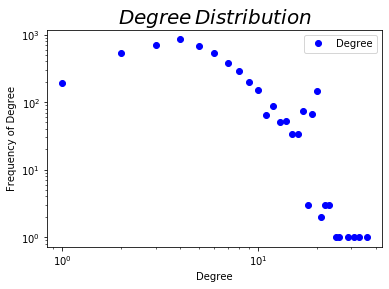

In [40]:
plotDegreeDistribution(G3,'degree_distribution_p2p_2013.png')

In [ ]:
savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

### Co-Authorship Network Visualization

In [88]:
# Visualize Co-Authorship Network

def co_author_network_vis(df):
    #Visualization 1989-1999
    df_co = df
    co_1 = nx.from_pandas_edgelist(df_co, source='AUTHOR', target='CO-AUTHOR') 

    # Plot it
    options = {'node_color': 'black','node_size': 1,'width': 0.005}

    nx.draw(co_1, **options)
    plt.show()

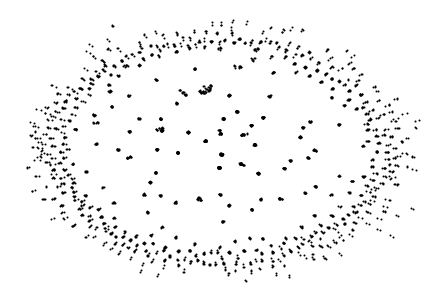

In [89]:
#Visualization until 2010

data_t1_vis = co_author_network_vis(data_t1)
data_t1_vis

In [90]:
#Visualization until 2015

#data_t2_vis = co_author_network_vis(data_t2)
#data_t2_vis

In [91]:
#Visualization until 2020

#data_t3_vis = co_author_network_vis(data_t3)
#data_t3_vis

----